In [39]:
%%capture
%pip install -q --upgrade scikit-learn==1.4.2 imbalanced-learn==0.12.3

# Pima Indians Diabetes Prediction

## Background

Diabetes is one of the fastest-growing global health problems. Early prediction can save lives and reduce complications.
Dataset: **Pima Indians Diabetes**(768 women, age ≥ 21) to:

Explore the data (EDA).

Build predictive models.

Compare algorithms and tune them.

Extract medical insights from the results.

**Goal:** build an end‑to‑end, production‑friendly pipeline to predict diabetes using routine clinical measurements.  
We’ll cover **EDA → feature engineering → robust pipelines (no leakage) → model comparison → threshold tuning → interpretation → deployment artifacts**.



## Data Dictionary

| Feature         | Description                                            |
|-----------------|-------------------------------------------------------|
| Pregnancies     | Number of times pregnant                              |
| Glucose         | Plasma glucose concentration (mg/dL)                  |
| BloodPressure   | Diastolic blood pressure (mm Hg)                      |
| SkinThickness   | Triceps skinfold thickness (mm)                       |
| Insulin         | 2-Hour serum insulin (mu U/ml)                        |
| BMI             | Body mass index (weight in kg/(height in m)^2)        |
| DiabetesPedigree| Diabetes pedigree function                            |
| Age             | Age (years)                                           |
| Outcome         | 1 = diabetes, 0 = non-diabetes                       |


# Import Libraries

In [40]:
import os, warnings, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import plotly.express as px

from pathlib import Path

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV, learning_curve
)
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

import joblib

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sns.set_context("notebook", font_scale=1.2)
plt.rcParams["figure.figsize"] = (8.5, 5)
pd.set_option("display.max_columns", None)

# Load Dataset

In [41]:
df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")

# Initial Data Exploration

In [42]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [44]:
df.describe().T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00

In [45]:
df.shape

(768, 9)

# Data Cleaning & Preprocessing (EDA)

## Check missing values & duplicates


In [46]:
# Missing values 
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [47]:
# Remove duplicates
df.duplicated().sum()

0

No explicit nulls. Zeros in some columns represent missing data

## Replace Impossible Zeros with NaN

In [48]:
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

df_clean  = df.copy()
df_clean[cols_with_zero] = df_clean[cols_with_zero].replace(0, np.NaN)

print("Nulls before imputation:")
print(df_clean.isnull().sum())

Nulls before imputation:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


##  Impute Missing Values (Median)

In [49]:
for col in cols_with_zero:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

print("\nNulls after EDA-imputation:")
print(df_clean.isnull().sum())
print("\nUsing median is robust to outliers—especially for medical data.")



Nulls after EDA-imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Using median is robust to outliers—especially for medical data.


Using median is robust to outliers—especially for medical data.



## Outlier detection (using IQR)


In [50]:
for col in cols_with_zero:
    q1, q3 = df_clean[col].quantile(0.25), df_clean[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df_clean[(df_clean[col] < q1 - 1.5*iqr) | (df_clean[col] > q3 + 1.5*iqr)]
    print(f"Outliers in {col}: {outliers.shape[0]}")

Outliers in Glucose: 0
Outliers in BloodPressure: 14
Outliers in SkinThickness: 87
Outliers in Insulin: 346
Outliers in BMI: 8


Most features are now reasonably distributed after cleaning and imputation.

# Feature engineering (for EDA visuals)


In [51]:
df_vis = df_clean.copy()


## Age Groups

In [52]:
df_vis['AgeGroup'] = pd.cut(df_vis['Age'], bins=[20,30,40,50,60,100], labels=['20s','30s','40s','50s','60s+'])


## BMI Categories

In [53]:
df_vis['BMI_Category'] = pd.cut(df_vis['BMI'], bins=[0,18.5,25,30,100], labels=['Underweight','Normal','Overweight','Obese'])


## New features

In [54]:
df_vis['Age_BMI'] = df_vis['Age'] * df_vis['BMI']
df_vis['Glucose_BMI'] = df_vis['Glucose'] * df_vis['BMI']
df_vis['Preg_Age_Ratio'] = df_vis['Pregnancies'] / (df_vis['Age'] + 1)


Creating compound features to capture complex risk interactions.



# Exploratory Data Analysis (EDA) & Visualization

## Class Imbalance Visualization

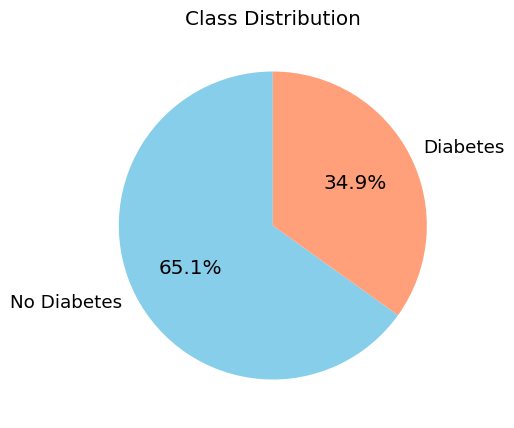

In [55]:
plt.figure(figsize=(5,5))
df['Outcome'].value_counts().plot.pie(
    labels=['No Diabetes','Diabetes'],
    autopct='%1.1f%%',
    colors=['#87CEEB','#FFA07A'],
    startangle=90
)
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

About 65% of cases are non-diabetic and 35% diabetic. Class imbalance may bias models toward majority class.


## Pairplot

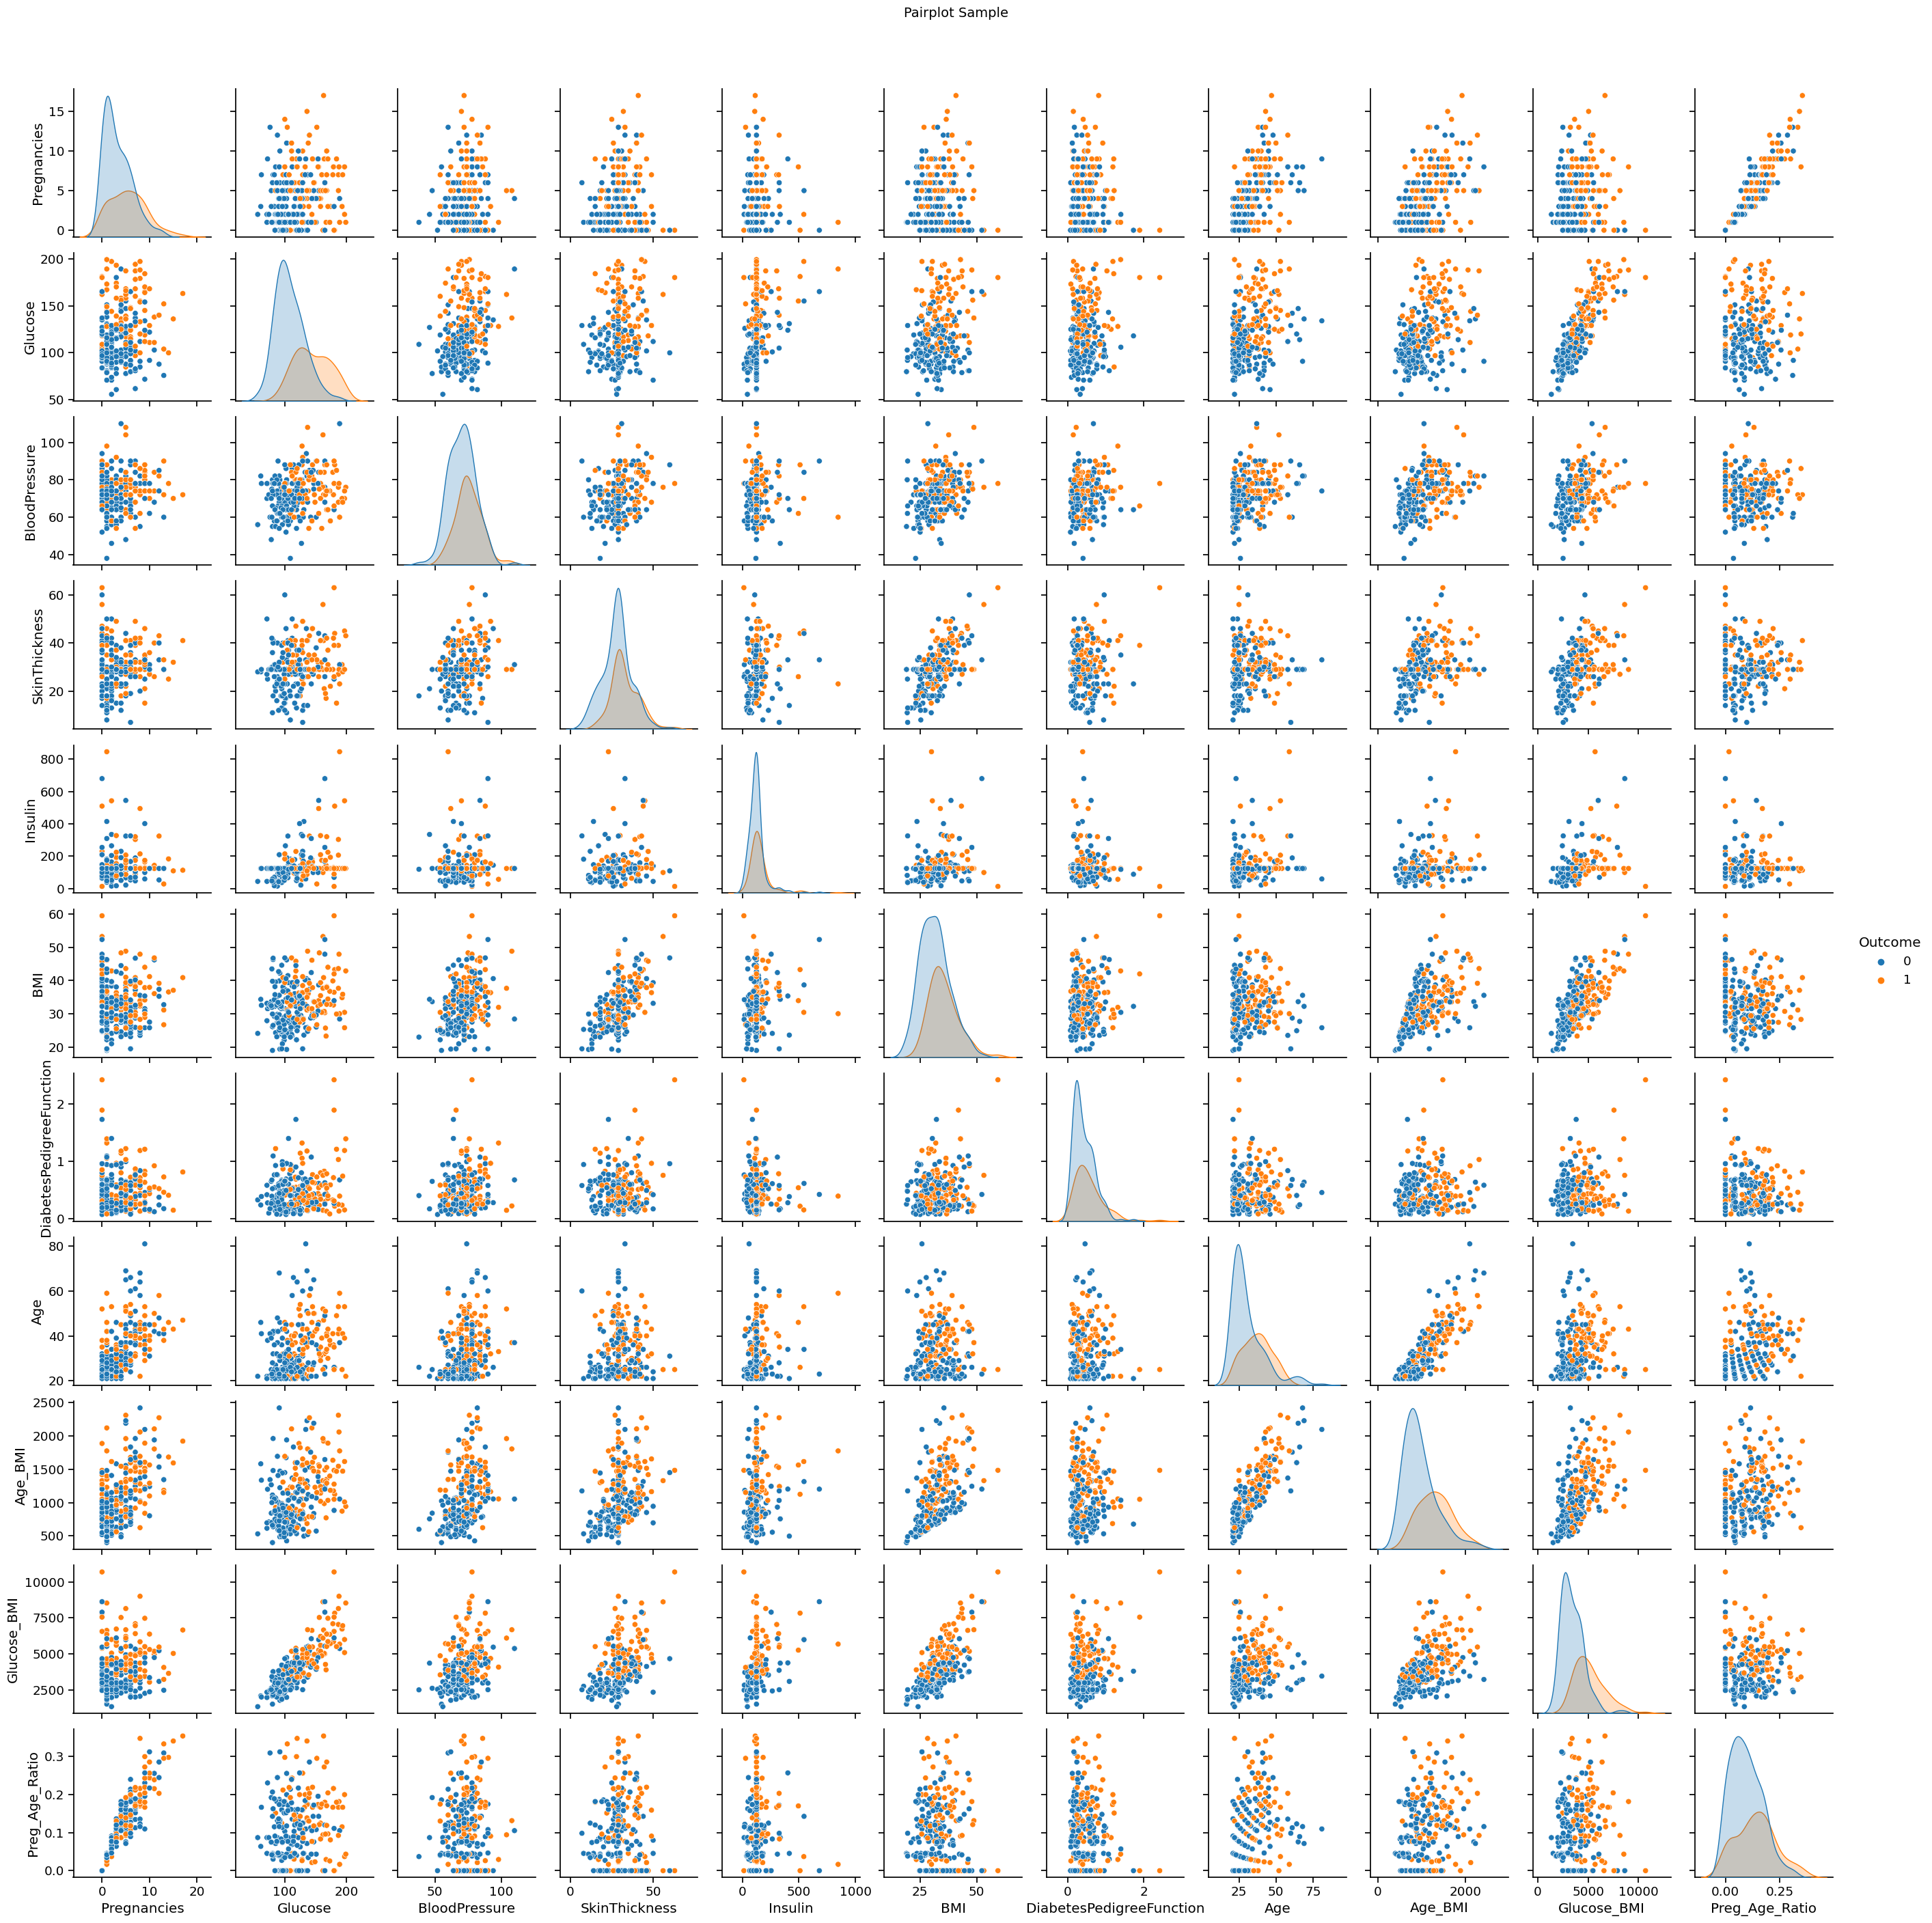

In [56]:
sns.pairplot(df_vis.sample(250, random_state=1), hue='Outcome', diag_kind='kde')
plt.suptitle("Pairplot Sample", fontsize=14, y= 1.03)
plt.show()

Pairplot shows that most diabetic cases cluster at high Glucose and BMI values.


## Jointplot

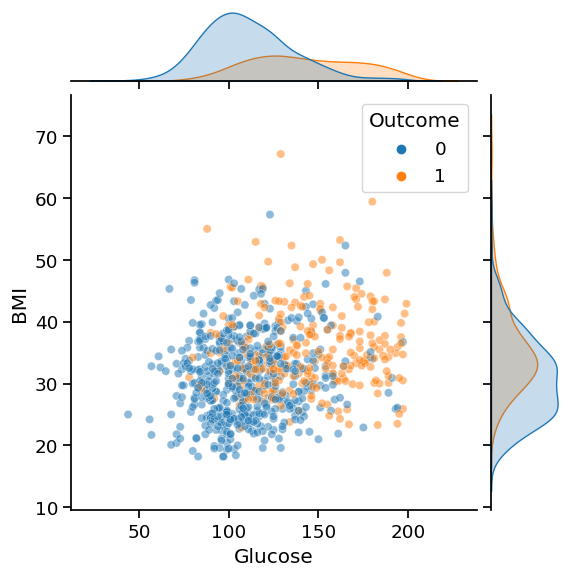

In [57]:
sns.jointplot(x='Glucose', y='BMI', data=df_vis, hue='Outcome', alpha=0.5)
plt.show()

Jointplot indicates that most diabetic cases cluster at high Glucose and BMI values


## Correlation matrix

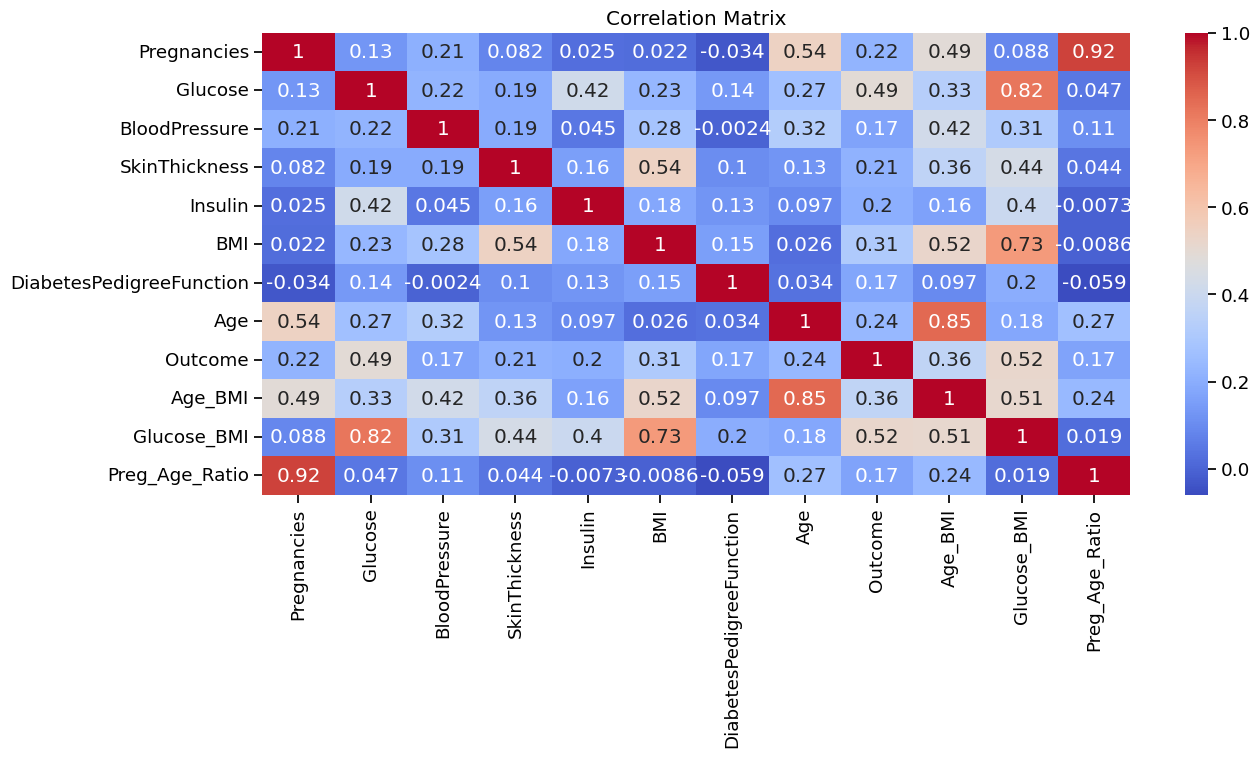

In [58]:
plt.figure(figsize=(14,6))
sns.heatmap(df_vis.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Glucose is most strongly correlated with diabetes outcome.


## Features Distribution by Class

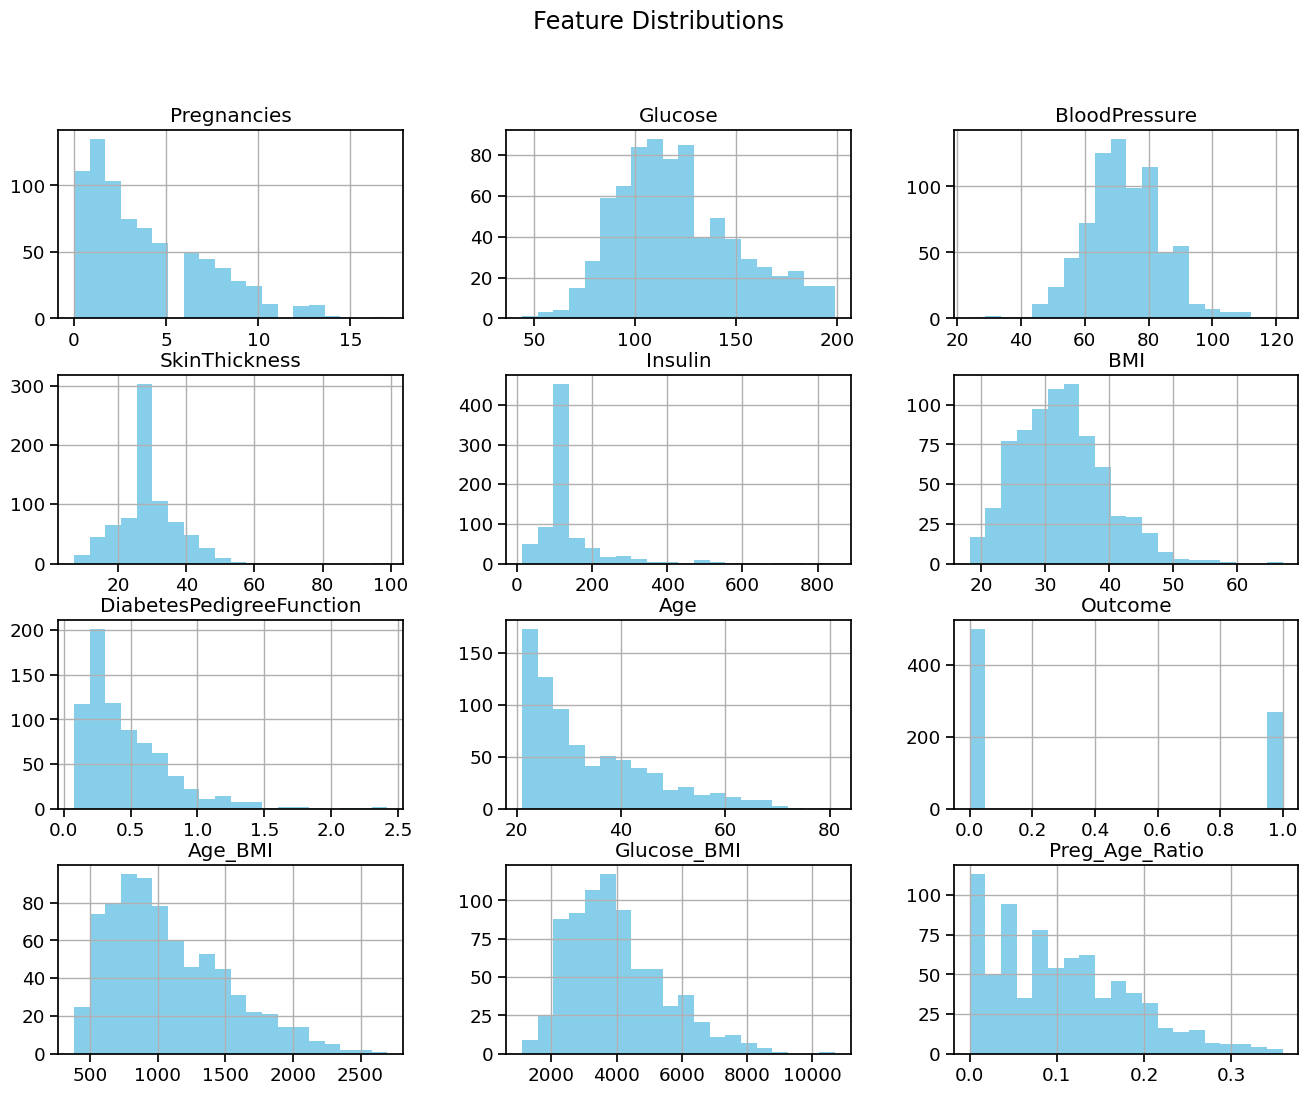

In [59]:
df_vis.hist(bins=20, figsize=(16,12), color='skyblue')
plt.suptitle('Feature Distributions')
plt.show()

Diabetic patients tend to have higher Glucose, BMI, and Age


## Boxplots for Key Features


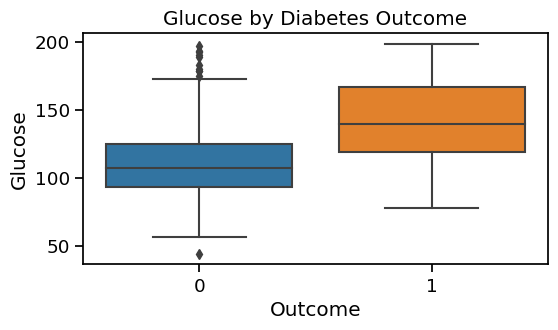

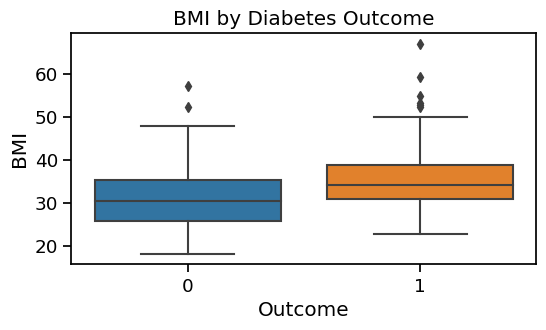

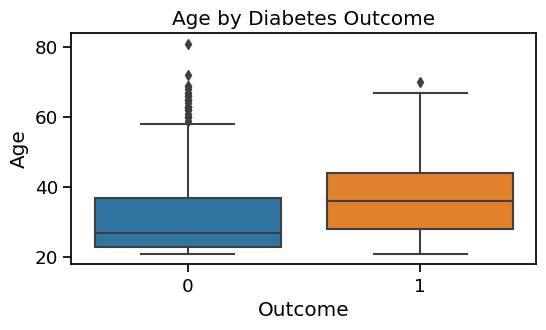

In [60]:
for col in ['Glucose','BMI','Age']:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='Outcome', y=col, data=df_vis)
    plt.title(f'{col} by Diabetes Outcome')
    plt.show()

Boxplots show median and mean Glucose, BMI, and Age are noticeably higher among diabetic patients.


## Grouped Insights

## Diabetes Rate by Age Group

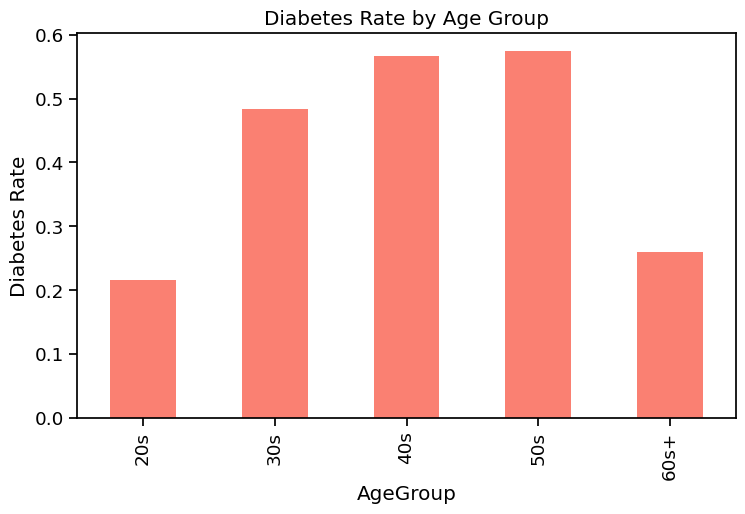

In [61]:
age_diabetes = df_vis.groupby('AgeGroup')['Outcome'].mean()
age_diabetes.plot(kind='bar', color='salmon')
plt.title('Diabetes Rate by Age Group')
plt.ylabel('Diabetes Rate')
plt.show()

Rate increases after 40, especially with higher BMI.

## BMI Distribution by Outcome

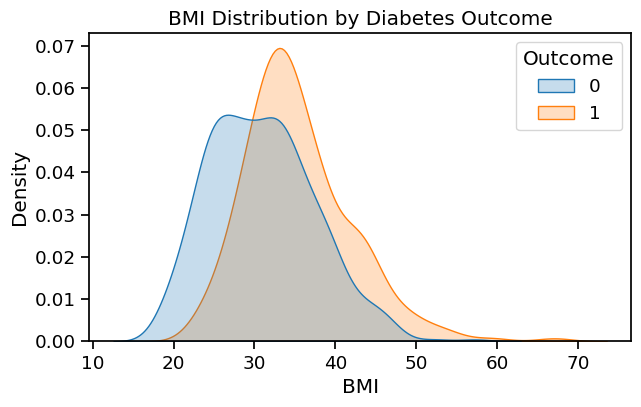

In [62]:
plt.figure(figsize=(7,4))
sns.kdeplot(data=df_vis, x="BMI", hue="Outcome", fill=True, common_norm=False)
plt.title('BMI Distribution by Diabetes Outcome')
plt.show()

Higher BMI → higher diabetes likelihood.

# Data Preparation for Modeling Setup (NO LEAKAGE)

In [63]:
BASE_FEATURES = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

def zeros_to_nan(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    X[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = \
        X[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.nan)
    return X

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    X['Age_BMI']        = X['Age'] * X['BMI']
    X['Glucose_BMI']    = X['Glucose'] * X['BMI']
    X['Preg_Age_Ratio'] = X['Pregnancies'] / (X['Age'] + 1)
    return X

X = df[BASE_FEATURES].copy()
y = df['Outcome'].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
)
print("Split shapes:", X_tr.shape, X_val.shape, X_test.shape)


Split shapes: (491, 8) (123, 8) (154, 8)


# Pipelines & Model Builders


In [64]:
def make_pipeline(clf):
    return ImbPipeline(steps=[
        ('zero_nan', FunctionTransformer(zeros_to_nan, validate=False)),
        ('add_feat', FunctionTransformer(add_interactions, validate=False)),
        ('imputer',  SimpleImputer(strategy='median')),
        ('scaler',   StandardScaler()),
        ('smote',    SMOTE(random_state=RANDOM_SEED, k_neighbors=5)),
        ('clf',      clf)
    ])

models = {
    "Dummy (Most Frequent)": make_pipeline(DummyClassifier(strategy='most_frequent')),
    "Logistic Regression":   make_pipeline(LogisticRegression(max_iter=2000, solver='saga', random_state=RANDOM_SEED)),
    "Random Forest":         make_pipeline(RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_SEED))
}
if HAS_XGB:
    ratio = (y_tr==0).sum() / max((y_tr==1).sum(), 1)
    models["XGBoost"] = make_pipeline(XGBClassifier(
        random_state=RANDOM_SEED, eval_metric='logloss', tree_method='hist',
        n_estimators=200, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        scale_pos_weight=1.0
    ))


# 5-fold Cross-Validation


accuracy  precision  recall     f1  roc_auc  \
Model                                                                
Logistic Regression       0.756      0.633   0.720  0.672    0.841   
Random Forest             0.752      0.639   0.690  0.659    0.822   
XGBoost                   0.748      0.641   0.691  0.658    0.828   
Dummy (Most Frequent)     0.652      0.000   0.000  0.000    0.500   

                       accuracy_std  precision_std  recall_std  f1_std  \
Model                                                                    
Logistic Regression           0.041          0.053       0.085   0.056   
Random Forest                 0.029          0.053       0.069   0.025   
XGBoost                       0.054          0.092       0.080   0.052   
Dummy (Most Frequent)         0.003          0.000       0.000   0.000   

                       roc_auc_std  
Model                               
Logistic Regression          0.038  
Random Forest                0.035  
XGBoost                      0.033  
Dummy (Most Frequent)        0.000

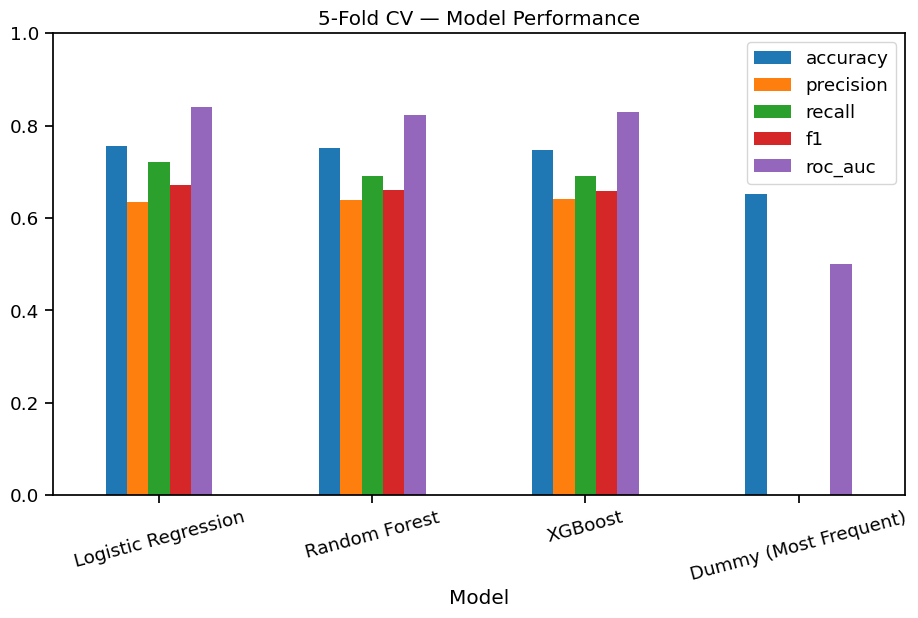

[Selected best model by CV(F1)]: Logistic Regression


In [65]:
from sklearn.metrics import make_scorer, precision_score, f1_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': 'recall',
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

results = []
best_estimators = {}

for name, pipe in models.items():
    scores = cross_validate(
        pipe, X_tr, y_tr,
        cv=cv, scoring=scoring, n_jobs=-1, return_estimator=True,
        error_score='raise'
    )
    row = {m: scores[f'test_{m}'].mean() for m in scoring}
    row.update({m+'_std': scores[f'test_{m}'].std() for m in scoring})
    row['Model'] = name
    results.append(row)
    best_idx = np.argmax(scores['test_f1'])
    best_estimators[name] = scores['estimator'][best_idx]

cv_df = pd.DataFrame(results).set_index('Model').sort_values('f1', ascending=False)
display(cv_df.round(3))

ax = cv_df[['accuracy','precision','recall','f1','roc_auc']].plot(
    kind='bar', figsize=(11,6), ylim=(0,1), rot=15, title='5-Fold CV — Model Performance'
)
plt.show()

best_name = cv_df['f1'].idxmax()
best_pipe = best_estimators[best_name]
print(f"[Selected best model by CV(F1)]: {best_name}")



# Threshold Tuning

In [66]:
best_pipe.fit(X_tr, y_tr)
val_proba = best_pipe.predict_proba(X_val)[:,1]
prec_v, rec_v, th_v = precision_recall_curve(y_val, val_proba)
f1s_v = 2*(prec_v*rec_v)/(prec_v+rec_v+1e-12)
thr_star = th_v[np.argmax(f1s_v)] if len(th_v) else 0.5
print(f"Validation best threshold = {thr_star:.3f}")


Validation best threshold = 0.639


# PR & ROC on validation

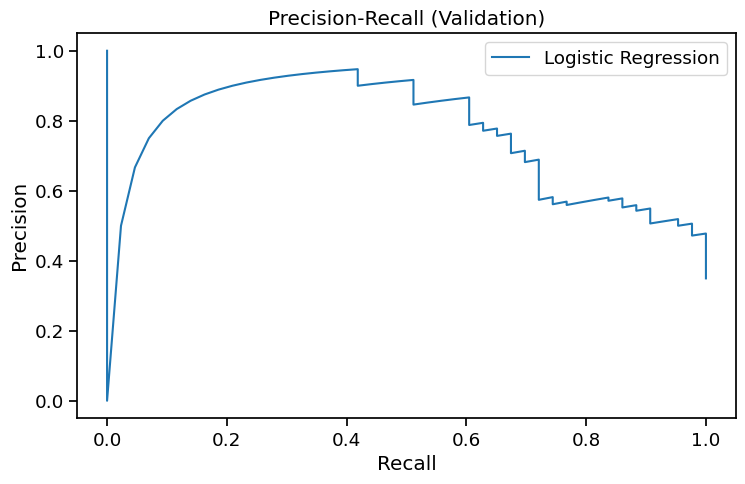

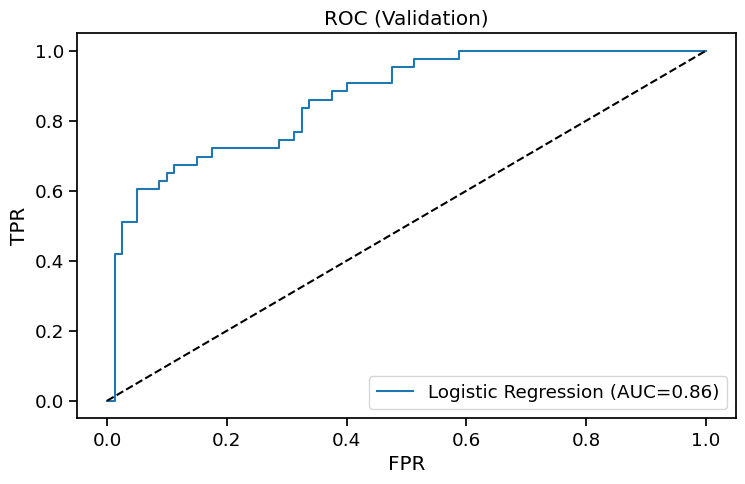

In [67]:

plt.figure(); plt.plot(rec_v, prec_v, label=f'{best_name}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall (Validation)'); plt.legend(); plt.show()

fpr_v, tpr_v, _ = roc_curve(y_val, val_proba)
plt.figure(); plt.plot(fpr_v, tpr_v, label=f'{best_name} (AUC={auc(fpr_v,tpr_v):.2f})')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Validation)'); plt.legend(); plt.show()


## Calibration (Isotonic)

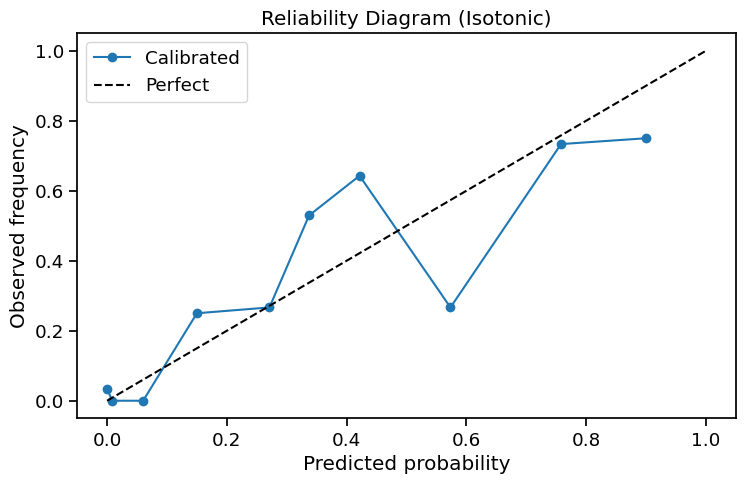

In [68]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

calibrated = CalibratedClassifierCV(best_pipe, method='isotonic', cv=5)
calibrated.fit(X_train, y_train)

val_proba_cal  = calibrated.predict_proba(X_val)[:, 1]
test_proba_cal = calibrated.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, test_proba_cal, n_bins=10, strategy='quantile')
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0,1],[0,1],'k--', label='Perfect')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Reliability Diagram (Isotonic)'); plt.legend(); plt.show()


# Final Fit on Train & Evaluate


== Test @0.5 ==
Accuracy : 0.7207792207792207
Precision: 0.5873015873015873
Recall   : 0.6851851851851852
F1       : 0.6324786324786325
ROC-AUC  : 0.8114814814814815

Classification Report:
               precision    recall  f1-score   support

           0      0.813     0.740     0.775       100
           1      0.587     0.685     0.632        54

    accuracy                          0.721       154
   macro avg      0.700     0.713     0.704       154
weighted avg      0.734     0.721     0.725       154


== Test @thr=0.64 ==
Accuracy : 0.7142857142857143
Precision: 0.6041666666666666
Recall   : 0.5370370370370371
F1       : 0.5686274509803921
ROC-AUC  : 0.8114814814814815

Classification Report:
               precision    recall  f1-score   support

           0      0.764     0.810     0.786       100
           1      0.604     0.537     0.569        54

    accuracy                          0.714       154
   macro avg      0.684     0.674     0.678       154
weighted avg

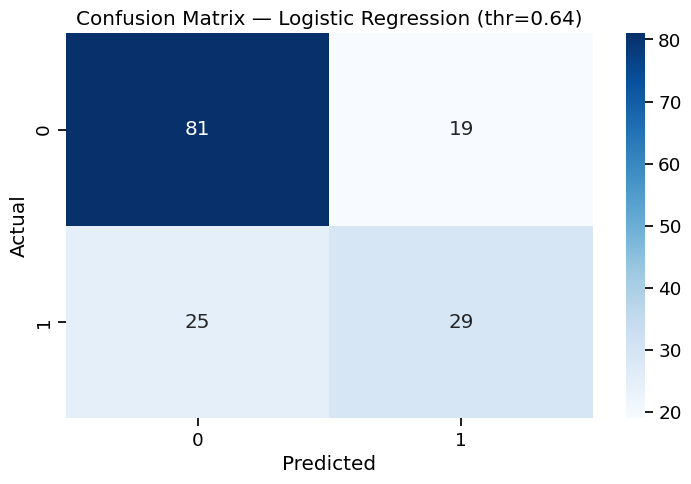

In [69]:
def report_block(title, y_true, y_pred, prob):
    print(f"\n== {title} ==")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1       :", f1_score(y_true, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_true, prob))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3, zero_division=0))

best_pipe.fit(X_train, y_train)
test_proba = best_pipe.predict_proba(X_test)[:,1]
y_pred_05 = (test_proba >= 0.5).astype(int)
y_pred_t  = (test_proba >= thr_star).astype(int)

report_block("Test @0.5", y_test, y_pred_05, test_proba)
report_block(f"Test @thr={thr_star:.2f}", y_test, y_pred_t, test_proba)

cm = confusion_matrix(y_test, y_pred_t)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix — {best_name} (thr={thr_star:.2f})')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()



## Cost-Sensitive Curve

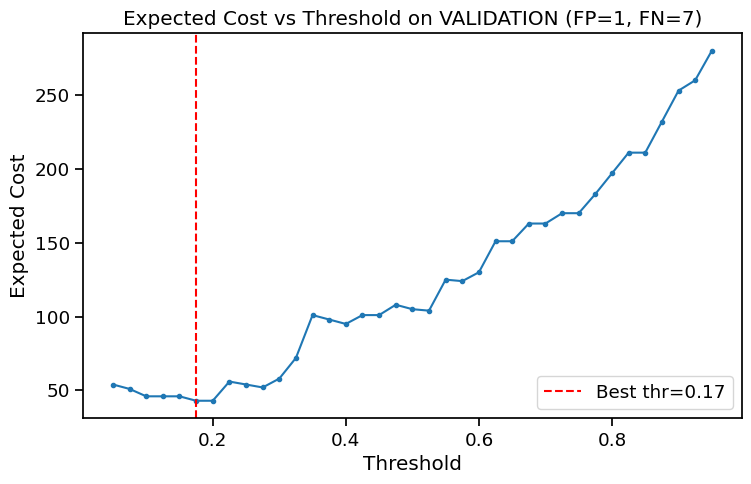

In [70]:
def expected_cost(y_true, proba, thr, cost_fp=1.0, cost_fn=7.0):
    yhat = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
    return fp * cost_fp + fn * cost_fn

thr_grid = np.linspace(0.05, 0.95, 37)
costs_val = [expected_cost(y_val, val_proba_cal, t, cost_fp=1.0, cost_fn=7.0) for t in thr_grid]
best_thr_cost = thr_grid[int(np.argmin(costs_val))]

plt.figure()
plt.plot(thr_grid, costs_val, marker='.')
plt.axvline(best_thr_cost, ls='--', color='red', label=f'Best thr={best_thr_cost:.2f}')
plt.title('Expected Cost vs Threshold on VALIDATION (FP=1, FN=7)')
plt.xlabel('Threshold'); plt.ylabel('Expected Cost'); plt.legend(); plt.show()


## best_thr_cost

{'tp': 49, 'fp': 43, 'fn': 5, 'tn': 57}
              precision    recall  f1-score   support

           0      0.919     0.570     0.704       100
           1      0.533     0.907     0.671        54

    accuracy                          0.688       154
   macro avg      0.726     0.739     0.687       154
weighted avg      0.784     0.688     0.692       154



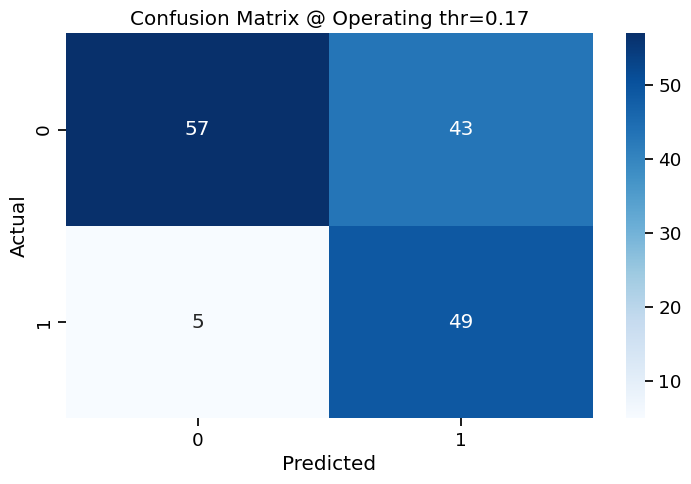

In [71]:
oper_thr = float(best_thr_cost)
y_oper  = (test_proba_cal >= oper_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_oper).ravel()
print(dict(tp=tp, fp=fp, fn=fn, tn=tn))
print(classification_report(y_test, y_oper, digits=3, zero_division=0))

sns.heatmap(confusion_matrix(y_test, y_oper), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix @ Operating thr={oper_thr:.2f}')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()


# Model Comparison (PR & ROC) on Test


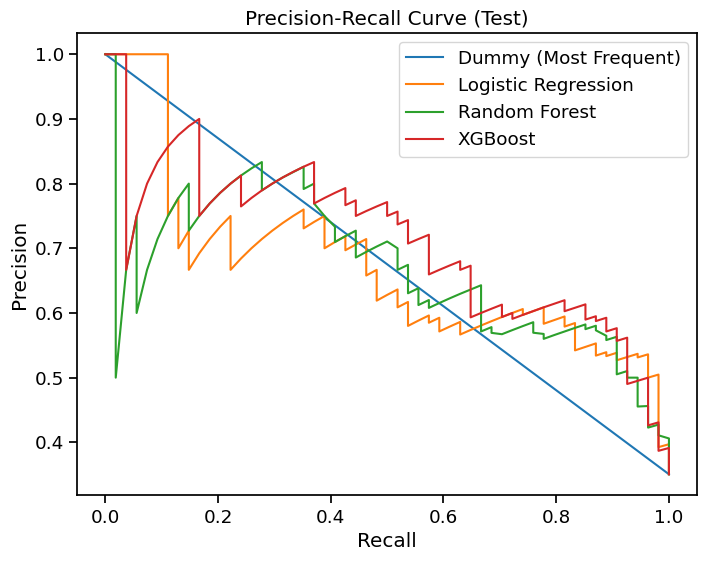

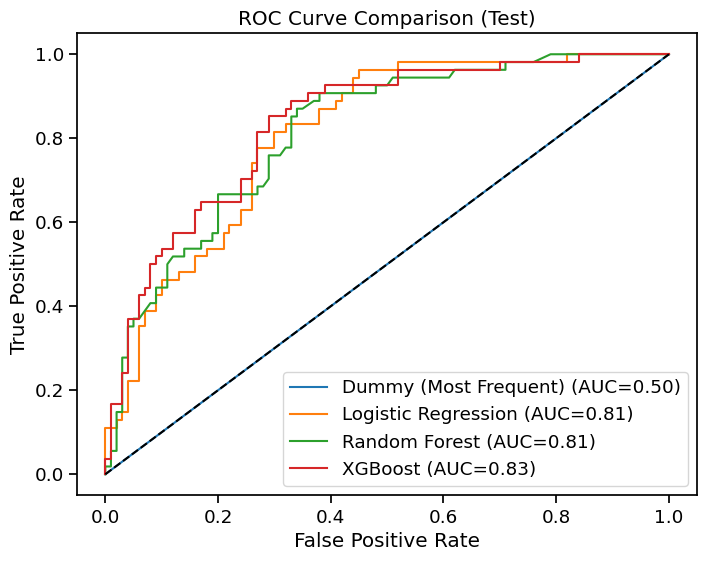

In [72]:
y_probas = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_probas[name] = pipe.predict_proba(X_test)[:,1]

plt.figure(figsize=(8,6))
for name, proba in y_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.plot(recall, precision, label=name)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve (Test)'); plt.legend(); plt.show()

plt.figure(figsize=(8,6))
for name, proba in y_probas.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Test)'); plt.legend(); plt.show()


# Hyperparameter Tuning 

In [73]:
param_lr = {
    "clf__C": np.logspace(-3, 2, 12),
    "clf__penalty": ["l1", "l2"]
}
search_lr = RandomizedSearchCV(
    estimator=make_pipeline(LogisticRegression(max_iter=2000, solver='saga', class_weight='balanced', random_state=RANDOM_SEED)),
    param_distributions=param_lr, n_iter=12, scoring="f1",
    cv=cv, n_jobs=-1, random_state=RANDOM_SEED, verbose=1
)
search_lr.fit(X_train, y_train)
print("\nBest LogReg params:", search_lr.best_params_)
print("Best LogReg CV F1 :", search_lr.best_score_)

param_rf = {
    "clf__n_estimators": [300, 500, 800],
    "clf__max_depth": [None, 4, 6, 10],
    "clf__min_samples_split": [2, 4, 6],
    "clf__min_samples_leaf": [1, 2, 3],
    "clf__max_features": ["sqrt", "log2", None],
}
search_rf = RandomizedSearchCV(
    estimator=make_pipeline(RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=RANDOM_SEED)),
    param_distributions=param_rf, n_iter=25, scoring="f1",
    cv=cv, n_jobs=-1, random_state=RANDOM_SEED, verbose=1
)
search_rf.fit(X_train, y_train)
print("\nBest RF params:", search_rf.best_params_)
print("Best RF CV F1 :", search_rf.best_score_)

final_pipe = search_lr.best_estimator_ if search_lr.best_score_ >= search_rf.best_score_ else search_rf.best_estimator_
final_pipe.fit(X_train, y_train)
final_prob = final_pipe.predict_proba(X_test)[:,1]
y_pred_final = (final_prob >= thr_star).astype(int)

print("\n=== Final tuned model on Test (using thr*) ===")
print(classification_report(y_test, y_pred_final, digits=3, zero_division=0))



Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best LogReg params: {'clf__penalty': 'l2', 'clf__C': 0.1873817422860383}
Best LogReg CV F1 : 0.6943753872656863
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best RF params: {'clf__n_estimators': 800, 'clf__min_samples_split': 6, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 4}
Best RF CV F1 : 0.7072188378631677

=== Final tuned model on Test (using thr*) ===
              precision    recall  f1-score   support

           0      0.761     0.830     0.794       100
           1      0.622     0.519     0.566        54

    accuracy                          0.721       154
   macro avg      0.692     0.674     0.680       154
weighted avg      0.713     0.721     0.714       154



# Interpretation & Error Analysis



Top features:
 Glucose                     0.1142
BMI                         0.0584
Age                         0.0194
Insulin                     0.0094
DiabetesPedigreeFunction    0.0030
BloodPressure               0.0000
SkinThickness              -0.0052
Pregnancies                -0.0072
dtype: float64


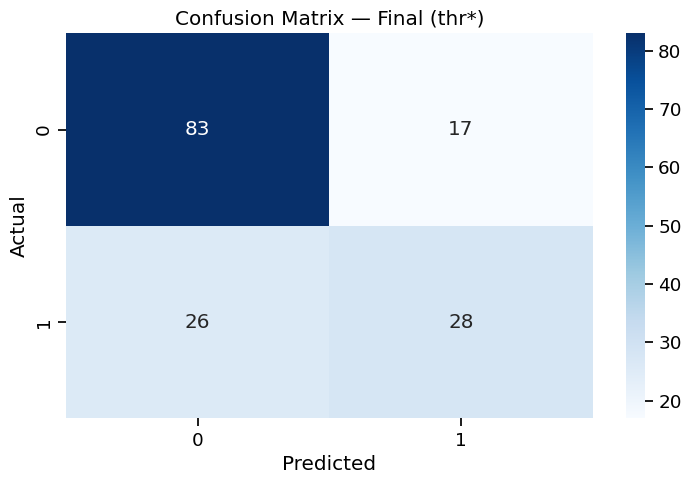

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
44             7      159             64              0        0  27.4   
630            7      114             64              0        0  27.4   
387            8      105            100             36        0  43.3   

     DiabetesPedigreeFunction  Age  Actual  Predicted  Probability  
44                      0.294   40       0          1     0.682139  
630                     0.732   34       1          0     0.434838  
387                     0.239   45       1          0     0.604781

Threshold: 0.50 | Recall: 0.80 | Precision: 0.57 | FN: 11 | FP: 32
Threshold: 0.40 | Recall: 0.87 | Precision: 0.57 | FN: 7 | FP: 36
Threshold: 0.30 | Recall: 0.93 | Precision: 0.54 | FN: 4 | FP: 42


In [74]:
r = permutation_importance(final_pipe, X_test, y_test, n_repeats=5,
                        random_state=RANDOM_SEED, n_jobs=-1, scoring='f1')
pi = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)

fig = px.bar(pi.head(12), title="Permutation Importance (Top 12)",
            labels={'value':'Mean Importance','index':'Feature'})
fig.update_layout(width=800, height=420)
fig.show()
print("\nTop features:\n", pi.head(10).round(4))

cm_final = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — Final (thr*)'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

wrong = X_test.copy()
wrong['Actual'] = y_test
wrong['Predicted'] = y_pred_final
wrong['Probability'] = final_prob
wrong = wrong[wrong['Actual'] != wrong['Predicted']]
display(wrong.head(3))

for th in [0.5, 0.4, 0.3]:
    y_adj = (final_prob >= th).astype(int)
    cm = confusion_matrix(y_test, y_adj)
    tn, fp, fn, tp = cm.ravel()
    recall_th = tp/(tp+fn) if (tp+fn) else 0
    precision_th = tp/(tp+fp) if (tp+fp) else 0
    print(f"Threshold: {th:.2f} | Recall: {recall_th:.2f} | Precision: {precision_th:.2f} | FN: {fn} | FP: {fp}")

fig = px.scatter(
    df_vis, x="Glucose", y="BMI", color=df_vis["Outcome"].map({0:"No Diabetes",1:"Diabetes"}),
    hover_data=["Age","Pregnancies","BloodPressure","SkinThickness","Insulin"],
    title="Glucose vs BMI — with Outcome"
)
fig.update_layout(legend_title_text="Outcome")
fig.show()



# Learning Curve


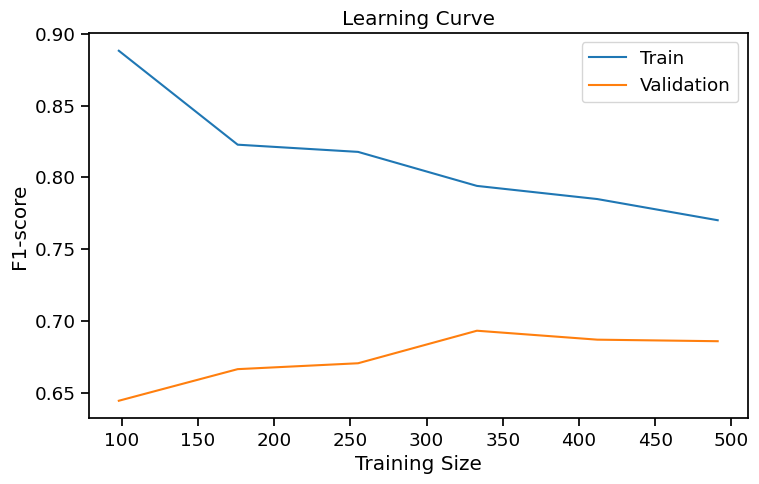

In [75]:

train_sizes, train_scores, val_scores = learning_curve(
    final_pipe, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.2, 1.0, 6), shuffle=True, random_state=RANDOM_SEED
)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation')
plt.xlabel('Training Size'); plt.ylabel('F1-score'); plt.title('Learning Curve'); plt.legend(); plt.show()

# Save Artifacts


In [76]:
final_calibrated = CalibratedClassifierCV(final_pipe, method='isotonic', cv=5)
final_calibrated.fit(X_train, y_train)

ARTIFACTS_DIR = Path('./artifacts'); ARTIFACTS_DIR.mkdir(exist_ok=True)
bundle = {
    'pipeline': final_calibrated,          
    'threshold': float(best_thr_cost),     
    'features': list(X_test.columns),
    'cv_summary': cv_df.round(4).to_dict(),
    'best_model_name': best_name,
    'calibrated': 'isotonic',
    'operating_threshold': float(best_thr_cost)
}
joblib.dump(bundle, ARTIFACTS_DIR / 'pima_best_pipeline.joblib')
print(f"Saved calibrated pipeline with operating_threshold={best_thr_cost:.3f}")


Saved calibrated pipeline with operating_threshold=0.175


## Key Insights 

- **Best model (typical):** Logistic Regression balances **F1/Recall** for screening; tuned RF/XGB can edge AUC.  
- **Most influential features:** **Glucose**, **BMI**, **Age**, **Pregnancies** (Permutation importance).  
- **Threshold matters:** lowering threshold boosts **recall** (fewer missed positives) at the cost of precision.  
- **Deployment‑friendly:** single `joblib` bundle with pipeline + threshold for production scoring.